In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

In [29]:
action_list = [[-1, 0], [0, -1], [0, 1], [1, 0]]

class Surround():
    def __init__(self, height, width):
        
        self.height = height
        self.width = width
        
        self.field = np.zeros([self.height + 2, self.width + 2])
        self.plA_coord = np.array([self.height // 2 + 1, self.width // 3 + 1])
        self.plB_coord = np.array([self.height // 2 + 1, 2 * (self.width // 3 + 1)])

        self.field[:, 0] = -1
        self.field[:, -1] = -1
        self.field[0, :] = -1
        self.field[-1, :] = -1

    def reset(self):
        self.__init__(self.height, self.width)
        return self

    def get_state(self):
        state = self.field.copy()
        state[self.plA_coord[0], self.plA_coord[1]] = 2
        state[self.plB_coord[0], self.plB_coord[1]] = -2
        return state

    def step(self, actionA, actionB):
        reward = 0
        
        self.field[self.plA_coord[0], self.plA_coord[1]] = -1
        self.field[self.plB_coord[0], self.plB_coord[1]] = -1
        
        self.plA_coord += actionA
        self.plB_coord += actionB

        collisionA = False
        collisionB = False
        collisionAB = False

        if self.field[self.plA_coord[0], self.plA_coord[1]] == -1:
            collisionA = True
        if self.field[self.plB_coord[0], self.plB_coord[1]] == -1:
            collisionB = True
        if self.plA_coord[0] == self.plB_coord[0] and self.plA_coord[1] == self.plB_coord[1]:
            collisionAB = True
        
        
        done = True
        #print(collisionA, collisionB, collisionAB)
        if collisionA and collisionB or collisionAB:
            reward = 0
        elif collisionA:
            reward = -1
        elif collisionB:
            reward = 1
        else:
            done = False
        
        return reward, done
    
    def print_state(self):
        for i in range(1, self.height + 1):
            for j in range(1, self.width + 1):
                if i == self.plA_coord[0] and j == self.plA_coord[1]:
                    print(' a', end = ' ')
                elif i == self.plB_coord[0] and j == self.plB_coord[1]:
                    print(' b', end = ' ')
                else:
                    print('{:2}'.format(int(self.field[i, j])), end = ' ')
            print('')
            
    def rollback(self, actionA, actionB):
        self.plA_coord -= actionA
        self.plB_coord -= actionB
        
        self.field[self.plA_coord[0], self.plA_coord[1]] = 0
        self.field[self.plB_coord[0], self.plB_coord[1]] = 0
        
        return self
        
    def is_terminal(self):
        done = False
        if self.field[self.plA_coord[0], self.plA_coord[1]] == -1 or self.field[self.plB_coord[0], self.plB_coord[1]] == -1:
            done = True
        return done
    
    def goto_state(self, backup):
        self.field = backup[0]
        self.plA_coord = backup[1]
        self.plB_coord = backup[2]
        return self
    
    def backup(self):
        return (game.field.copy(), game.plA_coord.copy(), game.plB_coord.copy())
    

In [365]:
class PolicyValueNet(nn.Module):
    def __init__(self, height, width, action_space, filters, conv_layers):
        super().__init__()
        self.conv_layers = conv_layers
        state_space = (height- 2 * (conv_layers-1)) * (width - 2 * (conv_layers - 1))
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, filters, 3),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(filters, 2 * filters, 3),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(2 * filters, 4 * filters, 3),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(4 * filters, 8 * filters, 3),
            nn.ReLU()
        )
        final_dim = state_space * 2 ** (conv_layers - 1) * filters
        self.lpA = nn.Sequential(
            nn.Flatten(start_dim = 0),
            #nn.Linear(final_dim, final_dim), 
            #nn.ReLU(),
            nn.Linear(final_dim, action_space)
        )
        self.lpB = nn.Sequential(
            nn.Flatten(start_dim = 0),
            #nn.Linear(final_dim, final_dim), 
            #nn.ReLU(),
            nn.Linear(final_dim, action_space)
        )
        self.lv = nn.Sequential(
            nn.Flatten(start_dim = 0),
            #nn.Linear(final_dim, final_dim),
            #nn.ReLU(),
            nn.Linear(final_dim, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        a = self.lpA(x)
        b = self.lpB(x)
        v = self.lv(x)
        action_probs_A = F.softmax(a, dim = 0)
        action_probs_B = F.softmax(b, dim = 0)
        #print(action_prob)
        return v, action_probs_A, action_probs_B


class actorcritic_Agent():
    def __init__(self, height, width, action_space, filters, conv_layers, from_file = False, path = 'first_model.pth'):
        self.actorcriticNet = PolicyValueNet(height, width, action_space, filters, conv_layers) 
        if from_file:
            self.actorcriticNet.load_state_dict(torch.load(path))
        self.optim = torch.optim.Adam(self.actorcriticNet.parameters(), lr = 0.001)
        

    def __call__(self, state):
        state = torch.from_numpy(state).float().unsqueeze(dim = 0)
        return self.actorcriticNet(state)
    
    def convert_action(self, action_probs):
        m = Categorical(action_probs)
        raw_action = m.sample()
        return raw_action.item()
    
    def train(self, action_list, value_and_count, sa_counts, str_to_state):
        #buffer will be a dict tensor: value
        total_loss = torch.tensor([0]).float()
        for state in value_and_count:
            true_v, c = value_and_count[state]
            if c == 0: 
                continue
            torch_state = torch.from_numpy(str_to_state[state]).float().unsqueeze(dim = 0)
            v, action_probsA, action_probsB = self.actorcriticNet(torch_state)
            #form dist to fit
            true_action_probsA = torch.tensor([0] * len(action_list)).float()
            true_action_probsB = torch.tensor([0] * len(action_list)).float()
            for n_, act in enumerate(action_list):
                sa_str_A = state + str(act) + 'A'
                sa_str_B = state + str(act) + 'B'
                if sa_str_A in sa_counts:
                    true_action_probsA[n_] = sa_counts[sa_str_A] / c
                if sa_str_B in sa_counts:
                    true_action_probsB[n_] = sa_counts[sa_str_B] / c
            
            #print(true_action_probsA)
            #print(true_action_probsB)
            #print(action_probsA)
            #print(action_probsB)
            #print(v, true_v)
            
            total_loss += 5 * (true_v - v) ** 2 \
                        + F.cross_entropy(action_probsA, true_action_probsA) \
                        + F.cross_entropy(action_probsB, true_action_probsB)
            
            #print((true_v - v) ** 2)
            #print(F.cross_entropy(action_probs, true_action_probs))
            #print(action_probs, true_action_probs)
        
        total_loss /= len(value_and_count)
        self.optim.zero_grad()
        total_loss.backward()
        self.optim.step()
        return total_loss.item()
    
    def save(self, path = 'first_model.pth'):
        torch.save(self.actorcriticNet.state_dict(), path)

    def pick_action(self, state, player_type):
        #перебор всех действий и выбор наилучшего матожидания
        v = np.empty((len(action_list), len(action_list)))
        for (nA, actA), (nB, actB) in itertools.product(enumerate(action_list), enumerate(action_list)):
            reward, done = game.step(actA, actB)
            v[nA, nB] = self.__call__(state)[0].item()
            if reward == -1 or reward == 1:
                v[nA, nB] = reward
            game.rollback(actA, actB)
        
        #print(v)
        #print(v.mean(axis = 1))
        #print(v.mean(axis = 0))
        
        if player_type == 'A':
            return action_list[np.argmax(v.mean(axis = 1))]
        elif player_type == 'B':
            return action_list[np.argmin(v.mean(axis = 0))]
        else:
            print('player_type should be A or B')
            
    def pick_action_policy_based(self, state, player_type):
        v, Aprobs, Bprobs = self.__call__(state)
        print(v, Aprobs, Bprobs)
        if player_type == 'A':
            return action_list[torch.argmax(Aprobs).item()]
        elif player_type == 'B':
            return action_list[torch.argmax(Bprobs).item()]
        else:
            print('player_type should be A or B')
        

In [549]:
#MCST algorithm for towo players game 

EXPL = 1.2


def pick_best_action(v, choose_max):
    
    best_act = np.array([0, 0])
    
    if choose_max:
        v[(v == -np.inf).all(axis = 1)] = -1e9
        values = v.mean(axis = 1, where = (v != -np.inf))
        idx = np.argmax(values)
        if values[idx] > -1e9:
            best_act = action_list[idx]
        #print(idx)
    else:
        v[(v == np.inf).all(axis = 1)] = 1e9
        values = v.mean(axis = 1, where = (v != np.inf))
        idx = np.argmin(values)
        if values[idx] < 1e9:
            best_act = action_list[idx]
        
    return best_act
    

def one_iteration(game, model, state, action_list, value_and_count, sa_counts, been, str_to_state):
    str_state = np.array2string(state, separator='')
    
    if str_state not in str_to_state:
        str_to_state[str_state] = state.copy()
    
    been[str_state] = True
    #pick the best action

    best_actA = np.array([0, 0])
    best_actB = np.array([0, 0])
    v_A = np.empty((len(action_list), len(action_list)))
    v_B = np.empty((len(action_list), len(action_list)))
    
    v_A[:, :] = -np.inf
    v_B[:, :] = -np.inf
    
    _, act_probsA, act_probsB = model(state)
    for (nA, actA), (nB, actB) in itertools.product(enumerate(action_list), enumerate(action_list)):
        reward, done = game.step(actA, actB)
        new_state = game.get_state()
        str_new_state = np.array2string(new_state, separator='')

        if str_new_state in been and been[str_new_state]:
            game.rollback(actA, actB)
            continue


        value, _A, _B = model(new_state)
        if done:
            value = 0
        
        sa_A_str = str_state + str(actA) + 'A'
        sa_B_str = str_state + str(actB) + 'B'
        if sa_A_str in sa_counts:
            curr_value_A = reward + value + EXPL * act_probsA[nA] * np.sqrt(value_and_count[str_state][1]) / (1 + sa_counts[sa_A_str])
        else:
            curr_value_A = reward + value + EXPL * act_probsA[nA] * np.sqrt(value_and_count[str_state][1])
        
        if sa_B_str in sa_counts:
            curr_value_B = -reward - value + EXPL * act_probsA[nB] * np.sqrt(value_and_count[str_state][1]) / (1 + sa_counts[sa_B_str])
        else:
            curr_value_B = -reward - value + EXPL * act_probsA[nB] * np.sqrt(value_and_count[str_state][1])
        
        v_A[nA, nB] = curr_value_A
        v_B[nB, nA] = curr_value_B

        game.rollback(actA, actB)
    #expanding
    #print(best_action, 'best')
    
    best_actA = pick_best_action(v_A, choose_max = True)
    best_actB = pick_best_action(v_B, choose_max = True)


    if best_actA[0] == 0 and best_actA[1] == 0 or best_actB[0] == 0 and best_actB[1] == 0:
        return 0
    
    saA = str_state + str(best_actA) + 'A'
    saB = str_state + str(best_actB) + 'B'
    if saA not in sa_counts:
        sa_counts[saA] = 0
    sa_counts[saA] += 1
    if saB not in sa_counts:
        sa_counts[saB] = 0
    sa_counts[saB] += 1
    
    reward, done = game.step(best_actA, best_actB)
    #game.print_state()
    #print(game.agent_coord)
    new_state = game.get_state()
    str_new_state = np.array2string(new_state, separator='')
    
    if done:
        value = reward
    elif str_new_state in value_and_count:
        value = one_iteration(game, model, new_state, action_list, value_and_count, sa_counts, been, str_to_state)
    else:
        value = simulate(game, model, new_state, action_list)
    
    if str_new_state not in value_and_count:
        value_and_count[str_new_state] = [value, 0]
    
    v, c = value_and_count[str_state]
    #print(v, c, 'vs values')
    #print(value)
    value_and_count[str_state] = [(v * c + value) / (c + 1), c + 1]
    #print(value_and_count[str_state])
    game.rollback(best_actA, best_actB)
    return value

def simulate(game, model, state, action_list):
    done = game.is_terminal()
    curr_state = state
    backup = game.backup() 
    total_score = 0
    while not done:
        value, act_probsA, act_probsB = model(curr_state)
        idxA, idxB = model.convert_action(act_probsA), model.convert_action(act_probsB)
        actionA, actionB = action_list[idxA], action_list[idxB]
        #game.print_state()
        #print()
        reward, done = game.step(actionA, actionB)
        total_score += reward
        curr_state = game.get_state()
    
    #game.print_state()
    game.goto_state(backup)
    return total_score

def mcts(game, model, state, action_list, value_and_count, sa_counts, str_to_state, n_iter):
    been = dict()
    for i in range(n_iter):
        for key in been:
            been[key] = False
        one_iteration(game, model, state, action_list, value_and_count, sa_counts, been, str_to_state)
    
    #pick the best action based on number of visits
    str_state = np.array2string(state, separator='')
    v, c = value_and_count[str_state]
    action_probsA = np.array([0.] * len(action_list))
    action_probsB = np.array([0.] * len(action_list))
    for n_, act in enumerate(action_list):
        sa_str_A = str_state + str(act) + 'A'
        sa_str_B = str_state + str(act) + 'B'
        if sa_str_A in sa_counts:
            action_probsA[n_] = sa_counts[sa_str_A] / c
        if sa_str_B in sa_counts:
            action_probsB[n_] = sa_counts[sa_str_B] / c
        
    best_actA = np.argmax(np.random.multinomial(1, action_probsA))
    best_actB = np.argmax(np.random.multinomial(1, action_probsB))
    """
    v_A = np.empty((len(action_list), len(action_list)))
    v_B = np.empty((len(action_list), len(action_list)))
    
    v_A[:, :] = -np.inf
    v_B[:, :] = np.inf
    
    for (nA, actA), (nB, actB) in itertools.product(enumerate(action_list), enumerate(action_list)):
        reward, done = game.step(actA, actB)
        new_state = game.get_state()
        str_new_state = np.array2string(new_state, separator='')
        
        if str_new_state not in value_and_count:
            game.rollback(actA, actB)
            continue
            
        v = value_and_count[str_new_state][0]
        v_A[nA, nB] = v
        v_B[nB, nA] = v
        game.rollback(actA, actB)
    
    best_actA = pick_best_action(v_A, choose_max = True)
    best_actB = pick_best_action(v_B, choose_max = False)
    """
    return action_list[best_actA], action_list[best_actB]


class random_Agent():
    def __init__(self, n_actions):
        self.nact = n_actions
    
    def convert_action(self, action_probs):
        return np.argmax(np.random.multinomial(1, action_probs, size = 1))
    
    def __call__(self, x):
        prob = 1./ self.nact
        act_probs = [prob] * self.nact
        return 0, np.array(act_probs), np.array(act_probs)

In [550]:
#how I see the game
"""
добавить интерактива и посмотреть на выдачу модели

 - изменить выдачу лучшего хода в mcts. Выбор должен происходить случайно по частотам посещения вершин. 
 - как настроить обучение? Как не переобучаться под плохие данные, которые генерирует mcts. 
        - может быть обучаться на подмножестве посещенных верщин, тогда можно будет убрать скореллированность. 
 - может быть переписать все через классы. В жопу рекурсию, слишком медленно. 
     - проверить, что dfs будет работать быстрее без рекурсии.
"""

'\nдобавить интерактива и посмотреть на выдачу модели\n\n - изменить выдачу лучшего хода в mcts. Выбор должен происходить случайно по частотам посещения вершин. \n - как настроить обучение? Как не переобучаться под плохие данные, которые генерирует mcts. \n        - может быть обучаться на подмножестве посещенных верщин, тогда можно будет убрать скореллированность. \n        \n'

In [567]:
#game = Surround(7, 11)
model = actorcritic_Agent(7, 11, 4, filters = 64, conv_layers = 3)
modelA = actorcritic_Agent(7, 11, 4, filters = 64, conv_layers = 3, from_file = True, path = 'model_3conv_64filters_2.pth')
modelB = actorcritic_Agent(7, 11, 4, filters = 64, conv_layers = 3, from_file = True, path = 'model_3conv_64filters.pth')
state = game.get_state()
value_and_count = dict()
sa_counts = dict()
str_to_state = dict()
value_and_count[np.array2string(state, separator='')] = [0, 0]
been = dict()
action_list = np.array([[-1, 0], [0, -1], [0, 1], [1, 0]])
game.print_state()

 0  0  0 -1  a  0  0 -1  0  0  0 
 0  0  0 -1  0  0  0 -1  0  0  0 
 0  0  0 -1  0  0  0 -1  0  0  0 
 0  0  0 -1  0  0  0 -1  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 


In [563]:
value_and_count = dict()
sa_counts = dict()
str_to_state = dict()
value_and_count[np.array2string(state, separator='')] = [0, 0]
been = dict()
mcts(game, model, state, action_list, value_and_count, sa_counts, str_to_state, 10)

(array([-1,  0]), array([ 0, -1]))

In [564]:
losses = list()
for i in range(50):
    losses.append(model.train(action_list, value_and_count, sa_counts, str_to_state))

In [511]:
actA, actB = np.array([0, 1]), np.array([1, 0])
for i in range(500):
    game.step(actA, actB)
    str_state = np.array2string(game.get_state(), separator='')
    game.rollback(actA, actB)

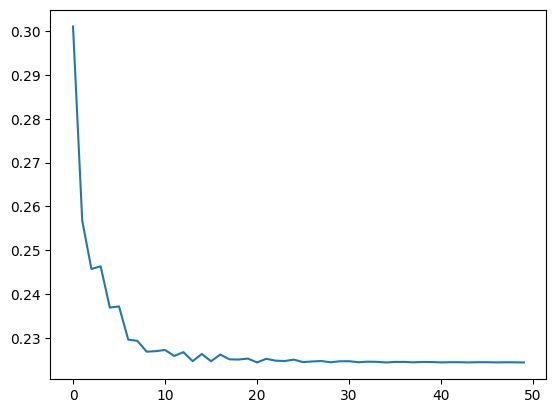

In [565]:
plt.plot(losses)

In [578]:
for key, value in value_and_count.items():
    print(key, value)

[[-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 2. 0. 0. 0.-2. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]] [0.87, 200]
[[-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 2. 0. 0. 0.-2. 0. 0. 0.-1.]
 [-1. 0. 0. 0.-1. 0. 0. 0.-1. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]] [-1, 0]
[[-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0.-1. 2. 0. 0.-1.-2.

In [574]:
for g in tqdm(range(30)):
    game.reset()
    #clearing
    value_and_count = dict()
    sa_counts = dict()
    str_to_state = dict()
    state = game.get_state()
    value_and_count[np.array2string(state, separator='')] = [0, 0]
    been = dict()
    done = False
    while not done:
        actA, actB = mcts(game, model, state, action_list, value_and_count, sa_counts, str_to_state, 50)
        #print(actA, actB)
        reward, done = game.step(actA, actB)
        #game.print_state()
        
        if done:
            for j in range(100):
                model.train(action_list, value_and_count, sa_counts, str_to_state)
            break


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [2:35:30<00:00, 311.03s/it]


In [60]:
model.save('simple_model.pth')

In [577]:
#play with model
def letter_to_action(letter, action_list):
    action = action = np.array([0, 0])
    if letter == 'w':
        action = action_list[0]
    elif letter == 'a':
        action = action_list[1]
    elif letter == 'd':
        action = action_list[2]
    elif letter == 's':
        action = action_list[3]
    return action 

done = False
game.reset()
game.print_state()

while not done:
    state = game.get_state()
    pl_act = input()
    while pl_act not in ['w', 'a', 's', 'd']:
        print('wasd, please')
        pl_act = input()
    pl_act = letter_to_action(pl_act, action_list)
        
    #ag_act = modelA.pick_action_policy_based(state, player_type = 'A')
    ag_act = model.pick_action(state, player_type = 'B')#input()
    #while ag_act not in ['w', 'a', 's', 'd']:
    #    print('wasd, please')
    #    ag_act = input()
    #ag_act = letter_to_action(ag_act, action_list)
    
    reward, done = game.step(pl_act, ag_act)
    
    game.print_state()


 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  a  0  0  0  b  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
d
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  b  0  0  0 
 0  0  0 -1  a  0  0 -1  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
d
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  b  0  0  0 
 0  0  0  0  0  0  0 -1  0  0  0 
 0  0  0 -1 -1  a  0 -1  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
w
 0  0  0  0  0  0  0  b  0  0  0 
 0  0  0  0  0  0  0 -1  0  0  0 
 0  0  0  0  0  a  0 -1  0  0  0 
 0  0  0 -1 -1 -1  0 -1  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
w
 0  0  0  0  0  0  b -1  0  0  0 
 0  0 

In [374]:
game.print_state()

 0  0  0  0  0  0  0  0  a  0  0 
 0  0  0  0  0  0  0  0 -1  0  0 
 0  0  0  0  0  0 -1 -1 -1  0  0 
 0  0  0 -1 -1 -1 -1 -1  0  0  0 
 0  0  0  0  0  0  0 -1  0  0  b 
 0  0  0  0  0  0  0 -1  0  0 -1 
 0  0  0  0  0  0  0 -1 -1 -1 -1 


In [343]:
done = False
game.reset()
game.print_state()

while not done:
    state = game.get_state()
    actA = modelA.pick_action_policy_based(state, player_type = 'A')
    actB = modelB.pick_action_policy_based(state, player_type = 'B')
    
    reward, done = game.step(actA, actB)
    
    game.print_state()


 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  a  0  0  0  b  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
tensor([0.9514], grad_fn=<TanhBackward0>) tensor([9.1708e-06, 4.6375e-06, 9.9954e-01, 4.4326e-04],
       grad_fn=<SoftmaxBackward0>) tensor([3.4093e-04, 1.1388e-03, 9.9404e-01, 4.4835e-03],
       grad_fn=<SoftmaxBackward0>)
tensor([0.5384], grad_fn=<TanhBackward0>) tensor([0.0307, 0.0045, 0.5667, 0.3981], grad_fn=<SoftmaxBackward0>) tensor([0.0161, 0.0027, 0.4245, 0.5567], grad_fn=<SoftmaxBackward0>)
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0 -1  a  0  0 -1  0  0  0 
 0  0  0  0  0  0  0  b  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0 
tensor([0.9981], grad_fn=<TanhBackward0>) tensor([1.0000e+00, 1.3097e-09, 1.0116e-08, 5.8865e-09],
       grad_fn=<Sof

In [534]:
np.argmax(np.random.multinomial(1, [0.25] * 4))

1

In [ ]:
[-0.02737296  0.00986214  0.11254833  0.0621203 ]
[ 0.02518128 -0.1461875   0.19798655  0.08017748]

In [279]:
torch.save(model.actorcriticNet.state_dict(), 'first_model.pth')

In [280]:
torch.load('first_model.pth').keys()

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'lpA.1.weight', 'lpA.1.bias', 'lpB.1.weight', 'lpB.1.bias', 'lv.1.weight', 'lv.1.bias'])

In [409]:
for key, value in value_and_count.items():
    print(key, value)

[[-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0.-1. 2. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0.-1.-1.-1. 0. 0. 0.-1.]
 [-1. 0. 0. 0.-1.-1.-1. 0.-1.-1. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0.-1. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0.-1. 0.-2.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0.-1.-1.-1.-1.]
 [-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]] [0.4100000000000002, 300]
[[-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0.-1.-1. 2. 0.-1.]
 [-1. 0. 0. 0. 0. 0.-1.-1.-1. 0. 0. 0.-1.]
 [-1. 0. 0. 0.-1.-1.-1. 0.-1.-1. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0.-1. 0.-2.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0.-1. 0.-1.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0.-1.-1.-1.-1.]
 [-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]] [0.0238095238095238, 84]
[[-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.-1.]
 [-1. 0. 0. 0. 0. 0. 0. 0.-1.-1.-1. 0.-1.]
 [-1. 0. 0. 0. 0. 0.-1.-1.-1. 0. 2. 0.-1.]
 